In [1]:
import os 
from pathlib import Path
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

2022-12-08 14:43:24.045036: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-08 14:43:24.966205: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/coleger/miniconda3/envs/tf/lib/
2022-12-08 14:43:24.966272: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/coleger/miniconda3/envs/tf/lib/
2022-12-08 14:43:24.966279: W tensorflow/compiler/tf

In [2]:
def get_data(path):
    data = pd.read_csv(path, names= ['Subject ID', 'Rooster ID', 'Age', 'Sexe', 'Group', 'Conversion', 'MMSE', 'RAVLT', 'FAQ', 'CDR-SB', 'ADAS11'], usecols = ['Subject ID', 'Rooster ID', 'Group'])
    data.index = data['Subject ID']
    data = data.drop(['Subject ID'], axis=1)
    data = data[((data.Group == 'AD') | (data.Group == 'CN'))]
    return data


In [3]:
path = str(Path().resolve())
path = path + "/ADNI1/"
filename = os.listdir(path)[2]
n_mmni_filename = os.path.join(path, filename)
img_n_mmni = nib.load(n_mmni_filename)


In [4]:
path = str(Path().resolve()) + "/ADNI1/list_standardized_tongtong_2017.csv"
y_data = get_data(path)
y_data.head()


,Rooster ID,Group
Subject ID,,
002_S_0295,295,CN
002_S_0413,413,CN
002_S_0559,559,CN
002_S_0619,619,AD
002_S_0685,685,CN


In [5]:
def reduce_shape(data):
    # shape now = (181, 217, 181)
    reduced_data = data[::2, ::2, ::2]
    # on prend juste 1 pixel sur 2
    return reduced_data

# problème : il faut qu'on ait le même format de données pourque ça fonctionne 

In [6]:
from tensorflow.keras.utils import to_categorical


def Data_preparation(Y):
    X_data = []
    Y_data = []
    
    path = str(Path().resolve()) + "/ADNI1"
    for index, _ in Y.iterrows():
        filename = path + '/n_mmni_fADNI_' + index + '_1.5T_t1w.nii.gz'
        
        if os.path.isfile(filename):
            img_n_mmni = nib.load(filename).get_fdata()
            reduced_shape_data = reduce_shape(img_n_mmni)
        
            X_data.append(reduced_shape_data)
            if Y['Group'][index] == 'AD':
                Y_data.append(1)
            elif Y['Group'][index] == 'CN':
                Y_data.append(0)
          
            
        else:
            Y.drop(index, inplace=True)
        
    X_data = np.array(X_data)   
    return X_data, Y_data


In [7]:
X_data, Y_data = Data_preparation(y_data)
Y_data = to_categorical(Y_data, num_classes=2)

print(X_data.shape)
print(len(Y_data))

(419, 91, 109, 91)
419


In [13]:
print(type(X_data))

<class 'numpy.ndarray'>


In [8]:
# on garde seulement une colonne pour y 
y_data = np.argmax(Y_data, axis= 1)

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=49) 

print("Data splited, length of training data is: ", len(X_train))
print("Data splited, length of test data is: ", len(X_test))

Data splited, length of training data is:  335
Data splited, length of test data is:  84


In [21]:
print(X_train.shape)
print(X_test.shape)

(335, 91, 109, 91)
(84, 91, 109, 91)


In [29]:
X_train_bis = X_train.reshape(335, 91, 109, 91,1)
print(X_train_bis.shape)
print(X_train_bis[0].shape)

(335, 91, 109, 91, 1)
(91, 109, 91, 1)


In [33]:
X_test_bis = X_test.reshape(84, 91, 109, 91,1)
print(X_test_bis.shape)
print(X_test_bis[0].shape)

(84, 91, 109, 91, 1)
(91, 109, 91, 1)


In [40]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout, BatchNormalization

model = Sequential()
# Couches de convolution + MaxPooling
model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(91,109,91,1)))
# input shape = (dim1, dim2,dim3, channels) no need to precise batch_size
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization(center=True, scale=True))
model.add(Dropout(0.3))
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization(center=True, scale=True))
model.add(Dropout(0.3))
# Couches de classification
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])
model.summary()

    

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 89, 107, 89, 32)   896       
                                                                 
 max_pooling3d_6 (MaxPooling  (None, 44, 53, 44, 32)   0         
 3D)                                                             
                                                                 
 batch_normalization_6 (Batc  (None, 44, 53, 44, 32)   128       
 hNormalization)                                                 
                                                                 
 dropout_6 (Dropout)         (None, 44, 53, 44, 32)    0         
                                                                 
 conv3d_7 (Conv3D)           (None, 42, 51, 42, 64)    55360     
                                                                 
 max_pooling3d_7 (MaxPooling  (None, 21, 25, 21, 64)  

In [41]:
# ajout d'un early stopping 
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, restore_best_weights=True)

history = model.fit(X_train_bis, y_train, epochs=80, validation_data=(X_test_bis, y_test),callbacks=[callback],batch_size=2)

Epoch 1/80
168/168 [==============================] - 17s 99ms/step - loss: 77.7858 - accuracy: 0.5134 - val_loss: 8.0150 - val_accuracy: 0.6190
Epoch 2/80
168/168 [==============================] - 16s 94ms/step - loss: 12.3060 - accuracy: 0.6179 - val_loss: 9.0488 - val_accuracy: 0.6310
Epoch 3/80
168/168 [==============================] - 15s 92ms/step - loss: 4.5170 - accuracy: 0.6716 - val_loss: 3.5441 - val_accuracy: 0.5000
Epoch 4/80
168/168 [==============================] - 15s 92ms/step - loss: 3.1248 - accuracy: 0.6627 - val_loss: 5.6709 - val_accuracy: 0.4167
Epoch 5/80
168/168 [==============================] - 16s 95ms/step - loss: 2.3658 - accuracy: 0.7493 - val_loss: 1.6140 - val_accuracy: 0.7262
Epoch 6/80
168/168 [==============================] - 15s 92ms/step - loss: 0.9392 - accuracy: 0.8657 - val_loss: 1.0225 - val_accuracy: 0.7143
Epoch 7/80
168/168 [==============================] - 16s 92ms/step - loss: 4.2582 - accuracy: 0.7463 - val_loss: 5.8430 - val_accurac

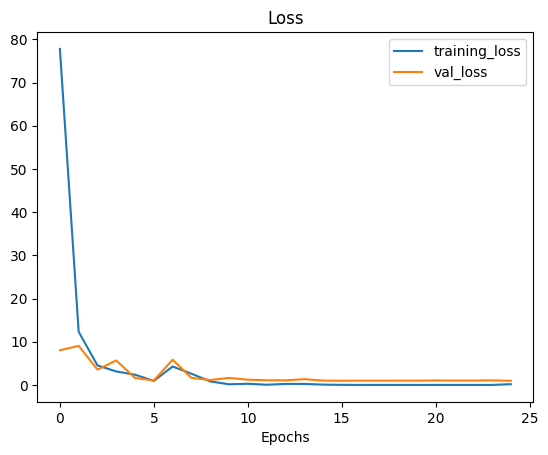

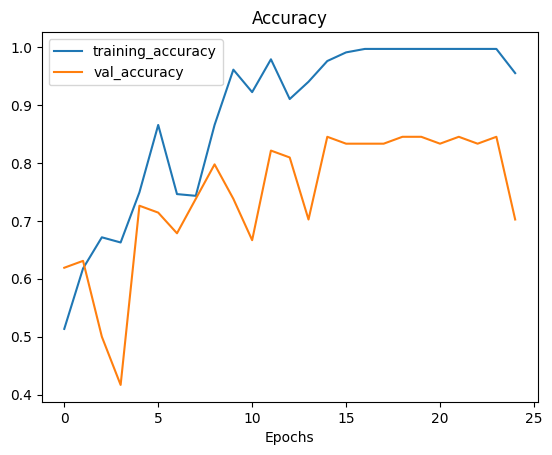

In [42]:
def plot_loss_curves(history):
    
      
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    # Plot loss
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

plot_loss_curves(history)

In [43]:
best_val_accuracy = np.max(history.history['val_accuracy'])
print(' Best val_accuracy value : {} '.format(best_val_accuracy))

 Best val_accuracy value : 0.8452380895614624 
